<a href="https://colab.research.google.com/github/vyomaa/drowsy-driver-detection/blob/main/VGGNET19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To further improve our model, we have explored another solution, the VGGNet-19 Model, made by the Visual Geometry Group in Oxford University, a model that is 19 layers deep. Here, I develop the model, run it, and analyze its effectiveness

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dheerajperumandla/drowsiness-dataset

 98% 158M/161M [00:01<00:00, 130MB/s]
100% 161M/161M [00:01<00:00, 116MB/s]


In [ ]:
!unzip drowsiness-dataset.zip

Archive:  drowsiness-dataset.zip
  inflating: train/Closed/_0.jpg     
  inflating: train/Closed/_1.jpg     
  inflating: train/Closed/_10.jpg    
  inflating: train/Closed/_100.jpg   
  inflating: train/Closed/_101.jpg   
  inflating: train/Closed/_102.jpg   
  inflating: train/Closed/_103.jpg   
  inflating: train/Closed/_104.jpg   
  inflating: train/Closed/_105.jpg   
  inflating: train/Closed/_106.jpg   
  inflating: train/Closed/_107.jpg   
  inflating: train/Closed/_108.jpg   
  inflating: train/Closed/_109.jpg   
  inflating: train/Closed/_11.jpg    
  inflating: train/Closed/_110.jpg   
  inflating: train/Closed/_111.jpg   
  inflating: train/Closed/_112.jpg   
  inflating: train/Closed/_113.jpg   
  inflating: train/Closed/_114.jpg   
  inflating: train/Closed/_115.jpg   
  inflating: train/Closed/_116.jpg   
  inflating: train/Closed/_117.jpg   
  inflating: train/Closed/_118.jpg   
  inflating: train/Closed/_119.jpg   
  inflating: train/Closed/_12.jpg    
  inflating: trai

In [ ]:
import os
labels = os.listdir("train")
labels

['Closed', 'yawn', 'Open', 'no_yawn']

PREPROCESSING

a) Normalization

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2023-07-22 17:52:20--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2023-07-22 17:52:21 (26.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
import cv2
def face_for_yawn(direc="train", face_cas_path="haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 224
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="train/", face_cas="haarcascade_frontalface_default.xml", eye_cas="haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 224
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train = get_data()

2
3


In [ ]:
import numpy as np
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [ ]:
new_data = append_data()

0
1
2
3


<ipython-input-11-e7f0d7d7581a>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 224, 224, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

b) Train test Split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 30
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

c) Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

DEEP LEARNING MODEL

2) VGGNET-19

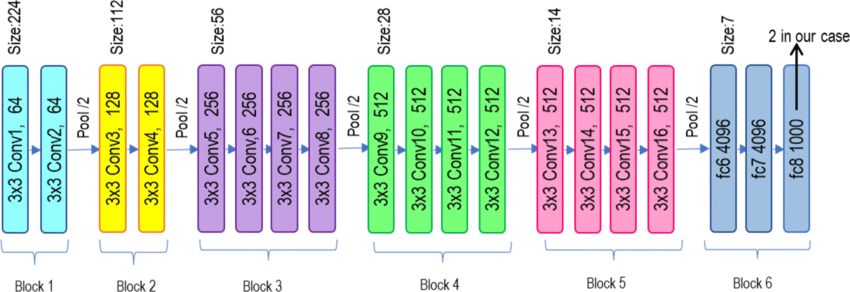

In [ ]:
modelVGG19 = Sequential()

modelVGG19.add(Conv2D(64, (3, 3), activation="relu", input_shape=(224,224,3), padding="same", trainable = False))
modelVGG19.add(Conv2D(64, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(MaxPooling2D(2, 2))

modelVGG19.add(Conv2D(128, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(128, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(MaxPooling2D(2, 2))

modelVGG19.add(Conv2D(256, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(256, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(256, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(256, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(MaxPooling2D(2, 2))

modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same", trainable = False))
modelVGG19.add(MaxPooling2D(2, 2))

modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
modelVGG19.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
modelVGG19.add(MaxPooling2D(2, 2))

modelVGG19.add(Flatten())
modelVGG19.add(Dropout(0.5))
modelVGG19.add(Dense(4096, activation="relu"))
modelVGG19.add(Dropout(0.5))
modelVGG19.add(Dense(4096, activation="relu"))
modelVGG19.add(Dense(1000, activation="relu"))
modelVGG19.add(Dense(4, activation="softmax"))

modelVGG19.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="sgd")

modelVGG19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
history = modelVGG19.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 [==============================] - 1720s 40s/step - loss: 1.3110 - accuracy: 0.3690 - val_loss: 1.2823 - val_accuracy: 0.3806
Epoch 2/10
43/43 [==============================] - 1710s 40s/step - loss: 1.2835 - accuracy: 0.3764 - val_loss: 1.2575 - val_accuracy: 0.3806
Epoch 3/10
43/43 [==============================] - 1728s 40s/step - loss: 1.2684 - accuracy: 0.3764 - val_loss: 1.2444 - val_accuracy: 0.3806
Epoch 4/10
43/43 [==============================] - 1712s 40s/step - loss: 1.2611 - accuracy: 0.3697 - val_loss: 1.2386 - val_accuracy: 0.3806
Epoch 5/10
43/43 [==============================] - 1690s 40s/step - loss: 1.2587 - accuracy: 0.3578 - val_loss: 1.2366 - val_accuracy: 0.3806
Epoch 6/10
43/43 [==============================] - 1729s 40s/step - loss: 1.2581 - accuracy: 0.3742 - val_loss: 1.2355 - val_accuracy: 0.3806
Epoch 7/10
43/43 [==============================] - 1723s 40s/step - loss: 1.2580 - accuracy: 0.3801 - val_loss: 1.2350 - val_accuracy: 0.3875

PERFORMANCE MEASURES

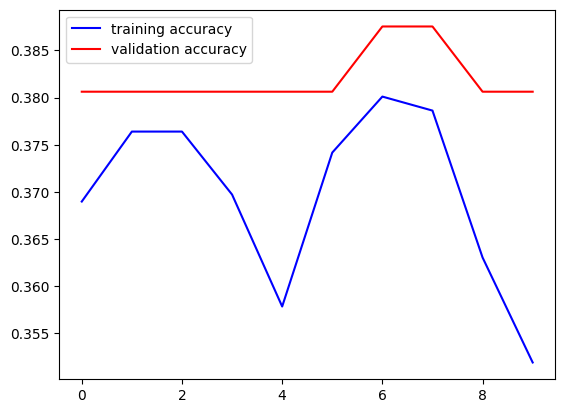

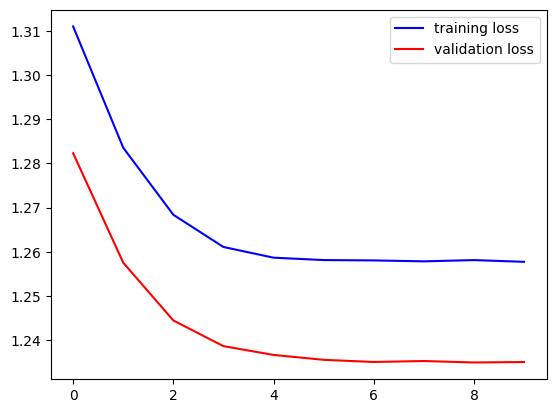

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

As shown, the VGGNet-19 model has given a training accuracy of 35.19% and a testing or validation accuracy of 38.06%.

Thus, it is useless and did not learning to differentiate between the categories.

These results have been represented in graphical form.


---

Accuracy Comparison of Drowsiness Detection Methods

Authors  | Method | Results
-------------------|------------------|---------------
[1] GWAK ET AL.      | ENSEMBLE MACHINE LEARNING     | 65.2 %
[2] JABBAR ET AL.      | CNN     | 83.33 %
[3] MEHTA ET AL. | EYE ASPECT RATIO AND EYE CLOSURE RATIO | 84 %
[4] KEPESIOVA ET AL. | CONV GRNN, CNN | 84.41 %
[5] DUA ET AL. | ALEXNET, VGG-FACENET, FLOWIMAGENET, RESNET | 85 %
[6] AYTEKIN ET AL. | TRANSFER LEARNING VGG16 | 91 %
METHOD1 | LeNet | 94.46 %
METHOD2 | VGGNet-19 | 38.06 %

References
[1] J. Gwak, A. Hirao, and M. Shino, “An investigation of early detection of driver drowsiness using ensemble machine learning based on hybrid sensing”,  Appl. Sci.,  vol.  10, no. 8,  Apr.  2020, Art no. 2890. https://doi.org/10.3390/app10082890

[2] R. Jabbar, M. Shinoy, M. Kharbeche, K. Al-Khalifa, M. Krichen, and K. Barkaoui, “Driver drowsiness detection model using convolutional neural networks techniques for android application”, in Proceedings of the 2020 IEEE  International  Conference  on  Informatics,  IoT,  and  Enabling Technologies, Doha, Qatar, May 2020, pp. 2–5. https://doi.org/10.1109/ICIoT48696.2020.9089484  

[3] S. Mehta, S. Dadhich, S. Gumber,  and A. J. Bhatt, “Real-time driver drowsiness detection system using eye aspect ratio and eye closure ratio”, in Proceedings of international conference on sustainable computing in science,  technology  and  management  (SUSCOM), Jaipur,  India,  Feb. 2019. https://doi.org/10.2139/ssrn.3356401

[4] Z. Kepesiova, J. Ciganek,  and S. Kozak, “Driver drowsiness detection using convolutional neural networks”, in 2020 Cybernetics & Informatics (K&I),  Velke Karlovice, Czech Republic,  Mar. 2020, pp. 1–6. https://doi.org/10.1109/KI48306.2020.9039851

[5] M. Dua, R. Singla, S. Raj,  and A. Jangra, “Deep CNN models-based ensemble approach to driver drowsiness detection”, Neural Computing and Applications, vol. 33, no. 8, pp. 3155–3168, Jul. 2021.  https://doi.org/10.1007/s00521-020-05209-7

[6] Alper Aytekin, Vasfiye Mençik, "Detection of Driver Dynamics with VGG16 Model", in Applied Computer Systems 27(1):83-88, June 2022. http://dx.doi.org/10.2478/acss-2022-0009





